## Import necessary packages

In [604]:
import numpy as np
import pandas as pd
from sklearn.metrics import roc_curve, auc, roc_auc_score, RocCurveDisplay
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from utils import load_magic_data
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from scipy.optimize import fsolve
from sklearn.datasets import load_svmlight_file
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable

seed = 1
torch.manual_seed(seed)
np.random.seed(seed)
# torch.backends.cudnn.deterministic = True
# torch.backends.cudnn.benchmark = False

## Load dataset

In [605]:
# (X, Y, _) = load_magic_data()
# X = MinMaxScaler(feature_range=(0,1)).fit_transform(X)
X, Y = load_svmlight_file('./data/german_scale.txt')
X = MinMaxScaler(feature_range=(0,1)).fit_transform(X.toarray())
# X = StandardScaler().fit_transform(X.toarray())
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size=0.1)
n, dim = np.shape(Xtrain)
inds = np.arange(len(Ytrain))
np.random.shuffle(inds)
Xtrain = Xtrain[inds,:]
Ytrain = Ytrain[inds]

# change labels from {0, 1} to {-1, 1}
Ytrain[Ytrain == 0] = -1
Ytest[Ytest == 0] = -1

Xtrain_pos = Xtrain[Ytrain==1,:]
Ytrain_pos = Ytrain[Ytrain==1]
Xtrain_neg = Xtrain[Ytrain==-1,:]
Ytrain_neg = Ytrain[Ytrain==-1]
n_pos, n_neg = len(Ytrain_pos), len(Ytrain_neg)
p = 4

## Run the P-Norm push algorithm

In [606]:
dik = np.ones((n_neg, n_pos)) / (n_pos*n_neg)
lam = np.zeros(dim)
T_max = 10
n_lrns = dim # use features as weak rankers

for t in range(T_max):
    max_score = -100000.0
    jmax = 0
    for j in range(n_lrns):
        sum_dik = np.power(np.sum(dik,axis=1), p - 1)  # size: [n_neg,]
        pred_pos = np.squeeze(Xtrain_pos[:,j]) # size: [n_pos,]
        pred_neg = np.squeeze(Xtrain_neg[:,j]) # size: [n_neg,]
        # weighted_dik = np.array([np.dot(np.squeeze(dik[k,:]), pred_pos - pred_neg[k]) for k in range(n_neg)])
        weighted_dik = np.squeeze(np.sum(dik * (pred_pos - pred_neg[:,None]), axis=1))
        new_score = np.dot(sum_dik, weighted_dik)
        if new_score >= max_score:
            max_score = new_score
            jmax = j

    # root finding
    pred_pos_max = np.squeeze(Xtrain_pos[:, jmax]) # size: [n_pos,]
    pred_neg_max = np.squeeze(Xtrain_neg[:, jmax])
    # func = lambda alpha: np.sum([np.power(np.dot(np.squeeze(dik[k,:]), np.exp(-alpha*(pred_pos_max-pred_neg_max[k]))),p-1)*np.sum((pred_pos_max-pred_neg_max[k]) * np.squeeze(dik[k,:]) * np.exp(-alpha*(pred_pos_max-pred_neg_max[k]))) for k in range(n_neg)])
    func = lambda alpha: np.sum(np.power(np.squeeze(np.sum(dik*np.exp(-alpha*(pred_pos_max - pred_neg_max[:,None])),axis=1)), p-1)*np.squeeze(np.sum((pred_pos_max - pred_neg_max[:,None])*dik*np.exp(-alpha*(pred_pos_max - pred_neg_max[:,None])),axis=1)))
    alpha_t = fsolve(func, x0=np.array(0.))

    # coordinate update
    lam[jmax] += alpha_t

    # update dik
    # z_t = np.sum([np.dot(np.squeeze(dik[k,:]), np.exp(-alpha_t*(pred_pos_max-pred_neg_max[k]))) for k in range(n_neg)])
    z_t = np.sum(np.sum(dik*np.exp(-alpha_t*(pred_pos_max - pred_neg_max[:,None]))))
    # for k in range(n_neg):
    #     dik[k,:] = dik[k,:] * np.exp(-alpha_t * (pred_pos_max-pred_neg_max[k])) / z_t
    dik = dik * np.exp(-alpha_t * (pred_pos_max - pred_neg_max[:,None])) / z_t

    # evaluation
    pred_pnp = np.dot(Xtest, lam)
    print("p: {0}, Iteration: {1}, AUC score:{2}".format(p, t, roc_auc_score(Ytest, pred_pnp)))


p: 4, Iteration: 0, AUC score:0.6223809523809524
p: 4, Iteration: 1, AUC score:0.6666666666666666
p: 4, Iteration: 2, AUC score:0.6654761904761904
p: 4, Iteration: 3, AUC score:0.6969047619047619
p: 4, Iteration: 4, AUC score:0.6985714285714285
p: 4, Iteration: 5, AUC score:0.6966666666666667
p: 4, Iteration: 6, AUC score:0.6921428571428572
p: 4, Iteration: 7, AUC score:0.6969047619047619
p: 4, Iteration: 8, AUC score:0.695952380952381
p: 4, Iteration: 9, AUC score:0.6980952380952381


## Run the FiSCO algorithm

In [607]:
class P_PUSH(torch.nn.Module):
    def __init__(self, margin, gamma, neg_data_length, poly=8):
        super(P_PUSH, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.poly = poly
        self.gamma = gamma
        self.u_neg = torch.tensor([0.0]*neg_data_length).view(-1, 1).to(self.device)
        self.margin = margin

    def forward(self,f_ps, f_ns, index_n):
        f_ps = f_ps.view(-1)
        f_ns = f_ns.view(-1)
        mat_data = f_ns.repeat(len(f_ps), 1).T  # neg x pos
        f_ps = f_ps.view(-1, 1)
        loss = torch.max(self.margin - (f_ps - mat_data), torch.zeros_like(mat_data)) ** 2 # size(neg, pos)
        self.u_neg[index_n] = (1 - self.gamma) * self.u_neg[index_n] + self.gamma * loss.mean(1)[:,None]
        p = self.poly*(self.u_neg[index_n]**(self.poly-1))
        p.detach_()
        loss = torch.mean(p * loss)

        return loss

class LinearModel(torch.nn.Module):
    def __init__(self, insize, outsize):
        super(LinearModel, self).__init__()
        self.linear = torch.nn.Linear(insize, outsize)

    def forward(self, x):
        return self.linear(x)

In [608]:
# Out is negative data, inner is positive data
model = LinearModel(insize=dim, outsize=1)
T_max = 500
B_o = 5
B_i = 5
push_loss = P_PUSH(margin=0.6, gamma=0.5, neg_data_length=n_neg, poly=p)
eta = 0.1
optimizer = torch.optim.SGD(model.parameters(), lr=eta, weight_decay=1e-4)
for t in range(T_max):
    model.train()
    inds_o = np.random.choice(n_neg, B_o)
    inds_i = np.random.choice(n_pos, B_i)
    if torch.cuda.is_available():
        X_neg_sampled = Variable(torch.from_numpy(Xtrain_neg[inds_o,:]).float().cuda())
        X_pos_sampled = Variable(torch.from_numpy(Xtrain_pos[inds_i,:]).float().cuda())
    else:
        X_neg_sampled = Variable(torch.from_numpy(Xtrain_neg[inds_o,:]).float())
        X_pos_sampled = Variable(torch.from_numpy(Xtrain_pos[inds_i,:]).float())

    optimizer.zero_grad()
    pred_neg = model.forward(X_neg_sampled)
    pred_pos = model.forward(X_pos_sampled)
    loss = push_loss.forward(f_ps=pred_pos, f_ns=pred_neg, index_n=inds_o)
    loss.backward()
    optimizer.step()
    # evaluation
    model.eval()
    if torch.cuda.is_available():
        test_tensor = Variable(torch.from_numpy(Xtest).float().cuda())
    else:
        test_tensor = Variable(torch.from_numpy(Xtest).float())
    pred_fisco = model.forward(test_tensor).detach().cpu().numpy()
    print("FISCO, p: {0}, Iteration: {1}, AUC score:{2}".format(p, t, roc_auc_score(Ytest, pred_fisco)))

FISCO, p: 4, Iteration: 0, AUC score:0.4928571428571428
FISCO, p: 4, Iteration: 1, AUC score:0.4947619047619048
FISCO, p: 4, Iteration: 2, AUC score:0.4852380952380952
FISCO, p: 4, Iteration: 3, AUC score:0.49238095238095236
FISCO, p: 4, Iteration: 4, AUC score:0.48142857142857143
FISCO, p: 4, Iteration: 5, AUC score:0.4847619047619048
FISCO, p: 4, Iteration: 6, AUC score:0.4861904761904762
FISCO, p: 4, Iteration: 7, AUC score:0.49000000000000005
FISCO, p: 4, Iteration: 8, AUC score:0.49142857142857144
FISCO, p: 4, Iteration: 9, AUC score:0.4923809523809524
FISCO, p: 4, Iteration: 10, AUC score:0.49142857142857144
FISCO, p: 4, Iteration: 11, AUC score:0.4923809523809524
FISCO, p: 4, Iteration: 12, AUC score:0.4980952380952381
FISCO, p: 4, Iteration: 13, AUC score:0.5076190476190476
FISCO, p: 4, Iteration: 14, AUC score:0.5066666666666666
FISCO, p: 4, Iteration: 15, AUC score:0.5142857142857142
FISCO, p: 4, Iteration: 16, AUC score:0.5076190476190476
FISCO, p: 4, Iteration: 17, AUC scor

Plot ROC curve

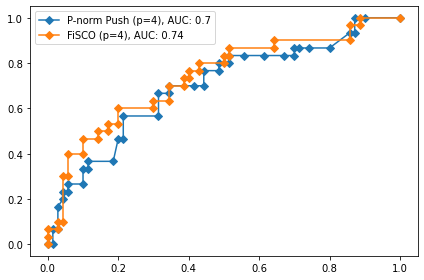

In [609]:
plt.figure(0).clf()
markers = ['D', 'o', 'v', '*', 'x' , '']
fpr_pnp, tpr_pnp, _ = roc_curve(Ytest, pred_pnp)
roc_auc_pnp = auc(fpr_pnp, tpr_pnp)
plt.plot(fpr_pnp, tpr_pnp, marker=markers[0], label='P-norm Push (p=' + str(p) + '), AUC: '+str(round(roc_auc_pnp,2)))
fpr_fisco, tpr_fisco, _ = roc_curve(Ytest, pred_fisco)
roc_auc_fisco = auc(fpr_fisco, tpr_fisco)
plt.plot(fpr_fisco, tpr_fisco, marker=markers[0], label='FiSCO (p=' + str(p) + '), AUC: '+str(round(roc_auc_fisco,2)))
plt.tight_layout()
plt.legend()
# plt.xlim(left=0, right=0.3)
# plt.ylim(bottom=0.0, top=0.2)
plt.show()

## to-dos

1. larger dataset, p-norm push infeasible